In [1]:
import cv2
import numpy as np
import os

In [2]:
def haar(img):
    status = False
    face_roi = []
    # Load Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Convert the image to grayscale (required for face detection)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image using the face_cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
    # Draw bounding boxes around the detected faces and display the image
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        face_roi = img[y:y+h, x:x+w]
        status = True
    return status,face_roi

In [3]:
#menentukan direktori/folder data citra yang akan dibuka
dirname = '../dataset_CV/'

#menentukan ukuran tinggi dan lebar gambar
height = 224
width = 224
dim = (width, height)

#mengumpulkan data citra yang akan dibuka dalam satu array
tampungan_data= []
tampungan_label=[]
for path, subdirs, files in os.walk(dirname):
    print(path)
    for name in files:
        img_path = (os.path.join(path, name))  #baca path data
        if (img_path.endswith("jpg")): #dengan file berekstensi jpg
            img = cv2.imread(img_path) #baca gambar

            path_parts = path.split('/')
            # Mengambil elemen terakhir dari path_parts sebagai kata terakhir
            last_word = path_parts[-1]
            #preprocessing data / segmentasi  boleh dilakukan disini
            status, gambar_haar = haar(img)
            if(status):
                resized=cv2.resize(gambar_haar,dim, interpolation=cv2.INTER_LINEAR) #resize
                tampungan_data.append(resized/255.0) #menumpuk gambar blur pada array tampungan dan di sampling
                tampungan_label.append(last_word)
    X = np.array(tampungan_data)
    y = np.array(tampungan_label)

../dataset_CV/
../dataset_CV/mahfud
../dataset_CV/siti
../dataset_CV/tomy


{'mahfud': 0, 'siti': 1, 'tomy': 2}


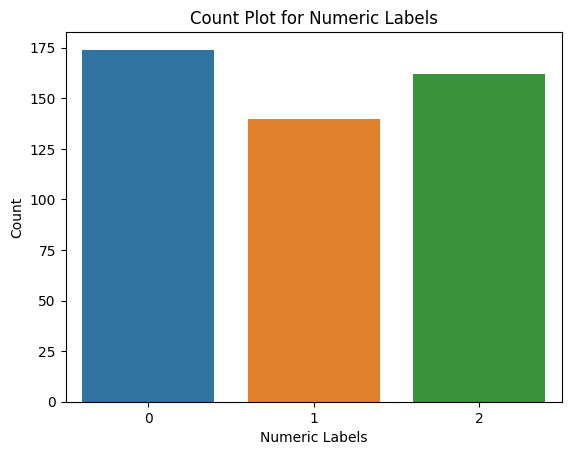

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

list_label=np.unique(y) #mendapatkan label unik
label_dict = {label: idx for idx, label in enumerate(list_label)} #masukkan dalam list
print(label_dict)
label_numerik = [label_dict[s] for s in y] #ubah kedalam numerik
label_numerik_array = np.array(label_numerik)

# Visualisasikan dalam jumlah dalam plot
sns.countplot(x=label_numerik_array)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()

# simpan dalam file npy untuk labeling
np.save('weight/label_knn.npy', label_dict)

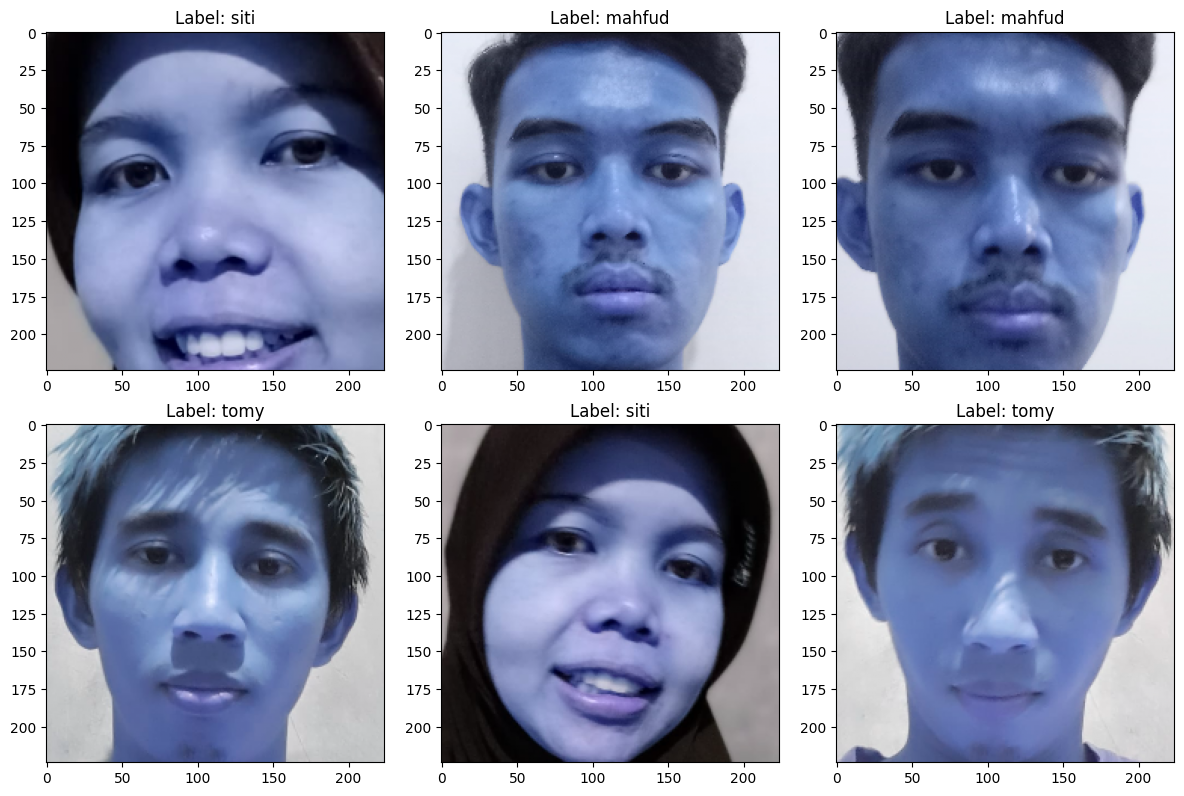

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 6 indices from the data
random_indices = np.random.choice(len(X), 6, replace=False)

# Plot the images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[idx])
    plt.title("Label: " + str(y[idx]))
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split #library untuk train test split

#melakukan splitting data


# First, split data into train and temp sets (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, label_numerik_array, test_size=0.3, random_state=42, stratify=label_numerik_array)

# Next, split the temp set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the sizes of each set
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (333, 224, 224, 3) (333,)
Validation set: (71, 224, 224, 3) (71,)
Test set: (72, 224, 224, 3) (72,)


In [7]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import MobileNetV2 as Mdl
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Model
def mobilenet(img_height,img_width, channel):
    base_model = Mdl(weights="imagenet", include_top=False, input_shape=(img_height,img_width, channel)) #model TF IMAGENET

    for layer in base_model.layers: #FREEZ ALL LAYER karena tfl
        layer.trainable = False

    model= tf.keras.Sequential()
    model.add(base_model) #tambahkan beberapa layer
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(3, activation="softmax")(x) #softmax untuk multiclass
    model = Model(inputs=model.input, outputs=predictions)
    return model
model=mobilenet(224,224, 3).summary() #tampilkan bentuk arsitekturnya

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input   [(None, 224, 224, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 64)                4014144   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195   

In [8]:
tf.keras.backend.clear_session() #hapus cache keras

model = mobilenet(224,224,3) #panggil model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy', metrics = ['accuracy']) #compile model
callbacks = [ModelCheckpoint(f"weight/best_weight.h5", monitor='val_loss', save_best_only=True)] #simpan model
history = model.fit(X_train,y_train,validation_data=(X_val,y_val), batch_size=32, epochs=30,
                          verbose=0, callbacks=callbacks, workers=-1) #train model

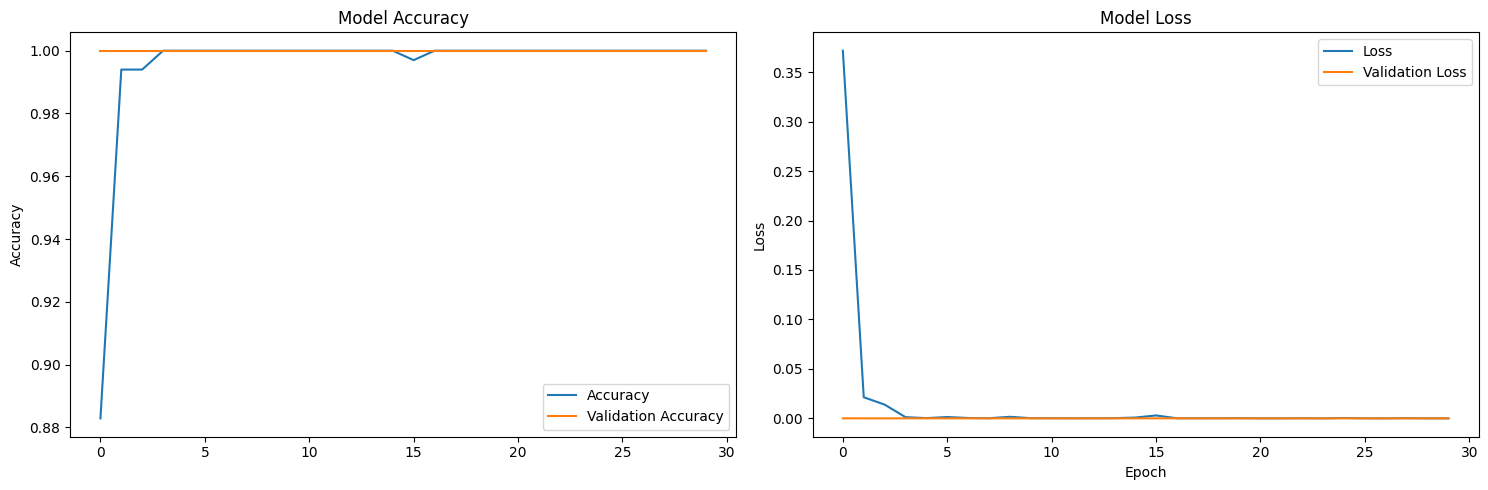

In [9]:
import matplotlib.pyplot as plt

# Plot grafik kiri
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

# Plot grafik kanan
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.tight_layout()
# Simpan gambar ke file
plt.show()

In [10]:
y_pred = model.predict(X_test, batch_size=1) #test model

72/72 [==============================] - 5s 18ms/step


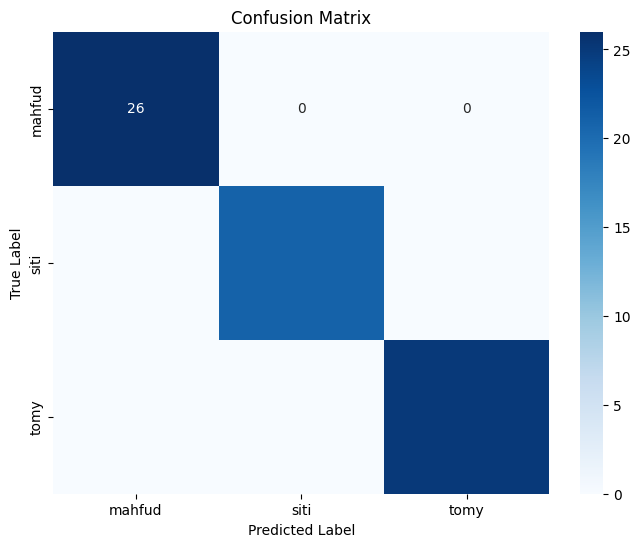

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
multiclass_predictions = np.argmax(y_pred, axis=1) #proses probabilitas
cm = confusion_matrix(multiclass_predictions, y_test)#plot cm
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
report = classification_report(multiclass_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        25

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



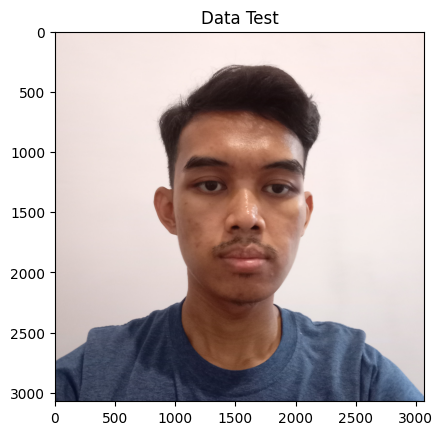

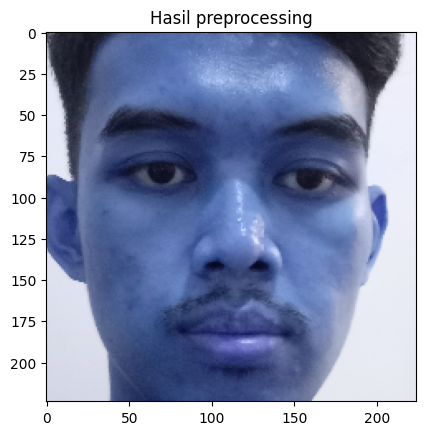

ukuran gambar test (1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
nilai probabilitas [[1.0000000e+00 4.5827542e-16 4.7962436e-15]]
mahfud = 100.0%
siti = 4.5827542352979605e-14%
tomy = 4.796243595697487e-13%
prediksinya: ['mahfud']
The predicted image is : [0] -> ['mahfud']


In [13]:
import matplotlib.pyplot as plt
import cv2
import os
import os.path
import numpy as np

url= '../dataset_CV/mahfud/IMG-20231101-WA0001.jpg'
img=cv2.imread(url)
plt.figure()
plt.title("Data Test")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#pastikan langkah preprocessing yang dilakukan sama dengan data train
status,haarnya=haar(img)
convert = haarnya/255.0
img_resize = cv2.resize(convert,(224,224))
#tampilkan hasil
plt.figure()
plt.title("Hasil preprocessing")
plt.imshow(img_resize)
plt.show()

test = img_resize.reshape((1, 224, 224, 3))

print(f"ukuran gambar test {test.shape}") #sama dengan input shape

# Mengecek hasil klasifikasi pada salah satu dataset
probability=model.predict(test)
print(f"nilai probabilitas {probability}") #tampilkan nilai probabilitas tiap kelas



for ind,val in enumerate(label_dict): #mendapatkan nama kelas dan hasil akurasi
    print(f'{val} = {probability[0][ind]*100}%')


hasil = np.argmax(probability, axis=-1) #mendapatkan kelas dari probabilitas terbaik
key_found = [key for key, value in label_dict.items() if value == hasil] #dapatkan namanya
print(f"prediksinya: {key_found}")
print(f"The predicted image is : {str(hasil)} -> {key_found}")

In [14]:
from tensorflow.keras.models import load_model
# Load the model
model_path ='weight/best_weight.h5'
model = load_model(model_path)

In [15]:
import cv2
import os
import os.path
import numpy as np
from time import sleep
import pickle


color = (255, 0, 0)
cap = cv2.VideoCapture(0) # 0 jika kamera
label_dict = np.load('weight/label_knn.npy', allow_pickle=True).item() #load label


while (cap.isOpened()):
    ret , frame = cap.read() #baca vidio dengan looping gambar
    if ret:
        face_roi = []# Load Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # Convert the image to grayscale (required for face detection)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image using the face_cascade
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
        # Draw bounding boxes around the detected faces and display the image
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            face_roi = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x-5, y-5), (x + w+5, y + h+5), (0, 255, 0), 4)#beri rectangle dan beri overlap sebesar 5

            convert = face_roi/255.0 #preprocessing
            muka = cv2.resize(convert, (224,224), interpolation = cv2.INTER_AREA)#wajib sama dengan citra inputan trainer
            cv2.imshow("Detect",muka)

            gambar_resize=muka.reshape((1, 224, 224, 3))
            probability= model.predict(gambar_resize) #prediksi
            hasil = np.argmax(probability, axis=-1) #mendapatkan kelas dari probabilitas terbaik
            key_found = [key for key, value in label_dict.items() if value == hasil] #dapatkan namanya
            cv2.putText(frame, f"Deteksi : {key_found[0]}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
            cv2.imshow("Detect",muka)
        cv2.imshow("Video Original" , frame)
    else:
        print('no video')
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 27ms/step


-1

In [16]:
import cv2
import numpy as np

color = (255, 0, 0)
video_path = input("Masukkan path video: ")  # Memasukkan path video secara manual
cap = cv2.VideoCapture(video_path)  # Membaca video dari file

label_dict = np.load('weight/label_knn.npy', allow_pickle=True).item()  # Load label

while cap.isOpened():
    ret, frame = cap.read()  # Baca frame video
    if ret:
        face_roi = []  # Load Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # Convert the image to grayscale (required for face detection)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image using the face_cascade
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
        # Draw bounding boxes around the detected faces and display the image
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            face_roi = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x-5, y-5), (x + w+5, y + h+5), (0, 255, 0), 4)  # Beri rectangle dan beri overlap sebesar 5

            convert = face_roi/255.0  # Preprocessing
            muka = cv2.resize(convert, (224, 224), interpolation=cv2.INTER_AREA)  # Wajib sama dengan citra inputan trainer
            cv2.imshow("Detect", muka)

            gambar_resize = muka.reshape((1, 224, 224, 3))
            probability = model.predict(gambar_resize)  # Prediksi
            hasil = np.argmax(probability, axis=-1)  # Mendapatkan kelas dari probabilitas terbaik
            key_found = [key for key, value in label_dict.items() if value == hasil]  # Dapatkan namanya
            cv2.putText(frame, f"Deteksi : {key_found[0]}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow("Detect", muka)
        cv2.imshow("Video Original", frame)
    else:
        print('Tidak ada video')
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

#../dataset_CV/Videotest2.mp4

Masukkan path video: ../dataset_CV/Videotest.mp4
1/1 [==============================] - 0s 25ms/step


-1